In [107]:
# HOME
import os
import scipy
# get the code
import sys
sys.path.append('../code')
from plot import plot_genomic

home = '/Users/mahtin'
# home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# tool-specific paths
shell_path = "../shell"
# 
cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

In [108]:
cnvPON_path

'/Users/mahtin/mount/scratch/develop/PONcoverage/chromCov'

## get the coverage and SNP data

In [109]:
sample = "01_A"
snp_df = pd.read_csv(os.path.join(output_path, 'heteroSNP/01_A.snp'), sep='\t')
cov_df = pd.read_csv(os.path.join(output_path, 'covDif/01_A.cov'), sep='\t')

## CovDiv rolling window

In [130]:
cov_df[:10]

,Chr,Pos,FullExonPos,ExonPos,Coverage,PONmeanCov,PONmedianCov,PONstd,log2ratio
0,chr1,12650,220,220,0.066480,0.005664,0.000000,0.018137,3.552918
1,chr1,12700,270,270,0.149581,0.024506,0.000000,0.070519,2.609726
2,chr1,12750,320,320,0.831005,0.016357,0.000000,0.053281,5.666868
3,chr1,13450,365,365,23.068687,10.565648,10.013362,4.855861,1.126555
4,chr1,13500,415,415,29.420886,14.981521,14.981521,6.335329,0.973657
5,chr1,13550,465,465,34.227416,18.105937,17.754565,7.737376,0.918690
6,chr1,13600,515,515,34.132682,17.593200,17.593200,7.753357,0.956136
7,chr1,13650,565,565,28.210943,13.517399,13.517399,6.162109,1.061437
8,chr1,14700,606,606,27.911782,14.335685,14.002403,5.515341,0.961263
9,chr1,14750,656,656,30.841904,16.343617,16.778470,6.290739,0.916165


### visualize the data

In [131]:
plots = [
    dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.1,
            alpha=.25
        )
    )
]

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-1.5,2.5)
)

12.059269


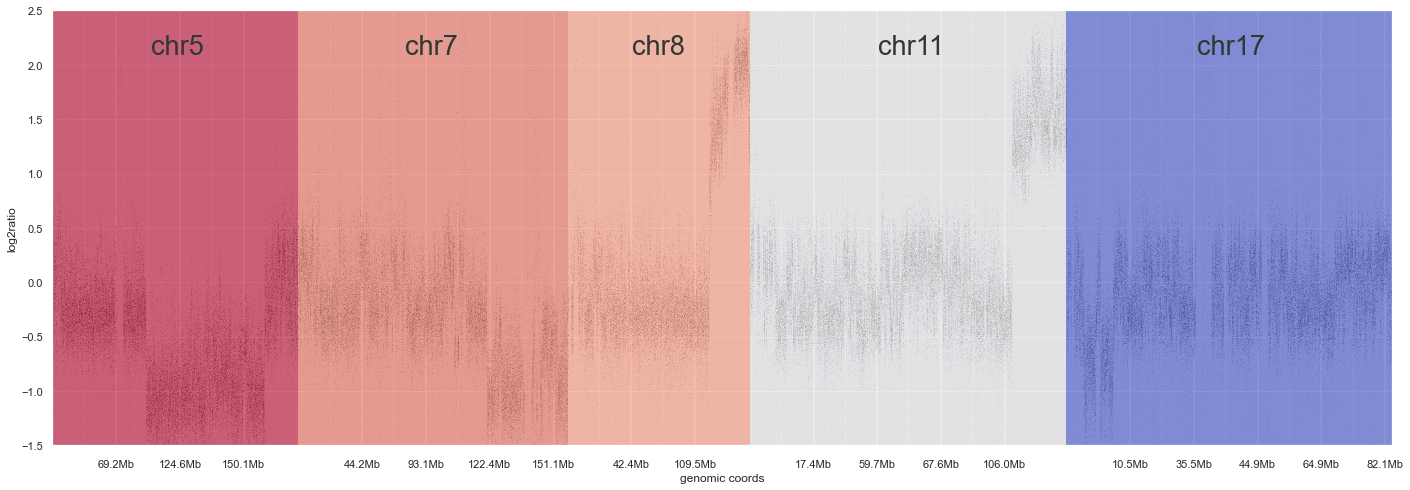

In [132]:
fig, ax, df, chrom_df = plot_genomic(cov_df, plots=plots, chroms=chroms, region='', **fig_params)

### try rolling window for log2ratio
#### compute the mean for log2ratio
+ this is all done on chromosome-basis
+ the rolling should be performed on coverage data filtered for:
    * minimal coverage
    * minimal coverage in PON samples
    * maximal std of PON coverage

In [190]:
def interpolate(df, col, expand_limit=20):
    cols = list(df.columns)
    # set FullExonPos as index for the interpolation method to work on proper intervals
    df = df.set_index('FullExonPos')
    df['interpol'] = df[col].interpolate(method='values', limit=expand_limit, limit_direction='both')
    df[col] = df['interpol']
    return df.reset_index()[cols]


def one_col_rolling(df, df_filter, col, agg, window_size=200, expand_limit=20, normalize=False, debug=False):

    # rolling left
    # get the right computation by passing agg to .agg()
    # only this allows passing methods as string
    df.loc[:,'L'] = df_filter[col].rolling(window_size).agg(agg)
    # rolling right by shifting the L column
    df.loc[:, 'R'] = df.shift(-window_size + 1)['L']
    org_cols = list(df.columns)
    
    col_name = col + agg
    diff_name = col_name + "Diff"
    new_cols += [col_name, diff_name]
    if debug:
        new_cols += ['L', 'R']
    # interpolate missing values
    for c in ['L', 'R']:
        df = interpolate(df, c, expand_limit=expand_limit)
    
    # normalize values 
    # not good for coverage and VAF
    if normalize:
    # normalize the data
        print('Normalizing data')
        _min = df['L'].min()
        _max = df['L'].max()
        for c in ['L', 'R']:
            df[c] = (df[c] - _min) / (_max - _min)
            
    # get the Diff
    df[diff_name] = ((df['R'] - df['L']) ** 2)
    df[diff_name] = df[diff_name] / df[diff_name].max()
    # here, contribution of L and R is controlled by diff value
    df[col_name] = df['R'] * df[diff_name] + df['L'] * (1 - df[diff_name])
    return df
    

# set the limits
rolling_params = dict(
    min_cov = 30,
    min_PON_cov = 50,
    max_PON_std = 100,
    window_size = 100
)

# restrict to chrom
df = cov_df.query('Chr == "chr17"')
# filter df
filter_df = df.query('Coverage >= @min_cov and PONmeanCov >= @min_PON_cov and PONstd < @max_PON_std')

# rolling mean
col = 'log2ratio'

df2 = one_col_rolling(df, filter_df, col, agg='mean', window_size=rolling_params['window_size'], debug=True)

df2.query('log2ratiomeanDiff == log2ratiomeanDiff')

/Users/mahtin/miniconda/envs/PDS-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mahtin/miniconda/envs/PDS-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


UnboundLocalError: local variable 'new_cols' referenced before assignment

0.546483


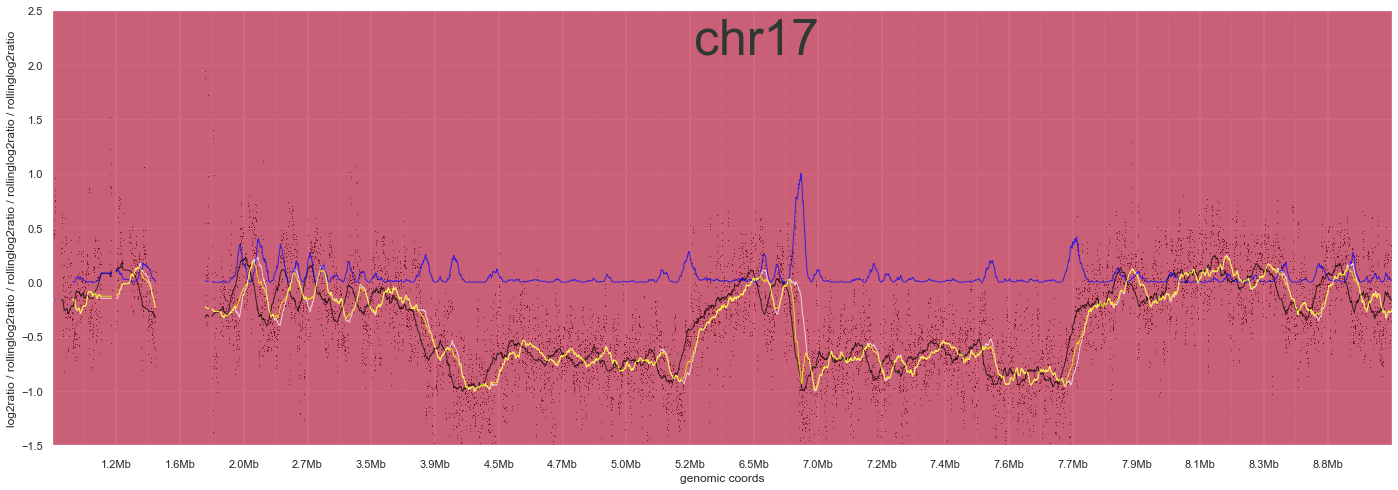

In [191]:
plots = [
    dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.5,
            alpha=.9
        )
    ),
    dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='L',
        plot_args=dict(
            linewidth=1,
            color='white',
            alpha=.7
        )
    ),
    dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='R',
        plot_args=dict(
            linewidth=1,
            color='black',
            alpha=.7
        )
    ),
    dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    ),
    dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )
]

_, _, _, _ = plot_genomic(df2, plots=plots, chroms=chroms, region='chr17:0-10Mb', **fig_params)

## heteroSNP rolling window
### first, get a few extra values to do rolling windows on

In [ ]:
def expand_SNPdata(snp_df, config):
    '''
    retrieve a few data columns locally to use rolling windows on
    this needs to be done chromosome-wise in order to avoid gap effects
    '''
    
    # reduce the snp_df using config limits
    VAFmin = config['VAFlimits'][0]
    VAFmax = config['VAFlimits'][1]
    minDepth = config['minDepth']
    minEBscore = config['minEBscore']
    df = snp_df.query('@VAFmin < VAF < @VAFmax and Depth >= @minDepth and EBscore > @minEBscore')
    
    # find the center
    center = df['VAF'].mean()
    print("heteroSNP centered around", center)
    # offCenter
    df.loc[:,'absVAF'] = np.abs(df['VAF'] - center)
    
    
    # get the local VAF difference chrom based
    dfs = []
    for chrom in df['Chr'].unique():
        chrom_df = df.query('Chr == @chrom')
        chrom_df['deltaVAF'] = np.abs(chrom_df['VAF'] - chrom_df.shift(1)['VAF']).fillna(0)
        dfs.append(chrom_df)
    snp_df = pd.concat(dfs).sort_values('FullExonPos')
    
    return snp_df

In [ ]:
config = {
    'heteroSNP': {
        'VAFlimits':[0.05,0.95],
        'normalize': True,
        'windows': {
            'absVAF': {
                'sum': 20
            },
            'VAF': {
                'std': 20
            },
            'deltaVAF': {
                'std': 20
            }
        },
        'minEBscore':0.5,
        'minDepth': 30,
    },
    'coverage': {
        'VAFlimits':[0.05,0.95],
        'normalize':False,
        'windows': {
            'log2ratio': {
                'mean':500
            },
            'Coverage': {
                'mean':500
            },
            'PONmeanCov': {
                'mean': 500
            }
        }
    }
}

snp_df = expand_SNPdata(snp_df, config['heteroSNP'])
snp_df

In [ ]:
def get_cols(col, agg='mean', modes=['L', 'R', 'Diff', '']):
    '''
    creates for each col a dict for looped computation
    {'L': 'VAVsumL', 'R': 'VAVsumR', 'Diff': 'VAVsumDiff', '': 'VAFsum'}}
    '''
    cols = {mode: col + agg + mode for mode in modes}
    return cols


def get_rolling_metrix_chrom(df, col='VAF', agg='sum', chrom='', window_size=20):
    '''
    take a column and produce rolling windows from it for each chromosome
    '''
    
    df = df.query('Chr == @chrom')
    cols = get_cols(col, agg)
    
    # get the right computation
    if agg =='std':
        df.loc[:, cols['L']] = df.rolling(window_size)[col].std()
    if agg == 'sum':
        df.loc[:, cols['L']] = df.rolling(window_size)[col].sum()
    if agg == 'mean':
        df.loc[:, cols['L']] = df.rolling(window_size)[col].mean()

    
    # get the right window by shifting the left
    df.loc[:, cols['R']] = df.shift(-window_size + 1)[cols['L']]
    # fillup the margins
    df.loc[:, cols['L']] = df[cols['L']].fillna(method='bfill')
    df.loc[:, cols['R']] = df[cols['R']].fillna(method='ffill')
    return df


def get_rolling_metrix(df, col='VAF', agg='mean', window_size=20, normalize=True):
    '''
    wrapper to apply get_rolling_metrix_chrom per chromosome
    '''
    
    chrom_dfs = []
    for chrom in df['Chr'].unique():
        chrom_df = get_rolling_metrix_chrom(df, col=col, agg=agg, chrom=chrom, window_size=window_size)
        chrom_dfs.append(chrom_df)
    df = pd.concat(chrom_dfs).sort_values('FullExonPos')
    
    cols = get_cols(col, agg)
    if normalize:
    # normalize the data
        print('Normalizing data')
        _min = df[cols['L']].min()
        _max = df[cols['L']].max()
        for side in ['L', 'R']:
            c = cols[side]
            df[c] = (df[c] - _min) / (_max - _min)
    # get the Diff
    df[cols['Diff']] = ((df[cols['L']] - df[cols['R']]) / 2) + 0.5
    df[cols['']] = df[cols['L']] * df[cols['Diff']] + df[cols['R']] * (1 - df[cols['Diff']])
    return df


def rolling_it(df, config):
    
    windows = config['windows']
    for col in windows.keys():
        for agg in windows[col].keys():
            window_size = windows[col][agg]
            print(f"Computing rolling window for {agg} of {col} with window size {window_size}")
            df = get_rolling_metrix(df, col=col, agg=agg, window_size=window_size, normalize=config['normalize'])
    return df

In [ ]:
rollingSNP_df = rolling_it(snp_df, config['heteroSNP'])
rollingSNP_df

In [ ]:
cov_df = rolling_it(cov_df, config['coverage'])

In [ ]:
def add_rolling_data(snp_df, cov_df, config):
    '''
    add the rolling metrices needed to get local data
    '''
    
    # add extra cols to snp_df
    snp_df = expand_SNPdata(snp_df, config['heteroSNP'])
    
    # get the rolling metrices for snp_df
    snp_df = rolling_it(snp_df, config['heteroSNP'])
    # get the rolling metrices for cov_df
    cov_df = rolling_it(cov_df, config['coverage'])
    
    return snp_df, cov_df

In [ ]:
snp_df, cov_df = add_rolling_data(snp_df, cov_df, config)

In [ ]:
snp_df.to_csv(os.path.join(output_path, 'heteroSNP/01_A.snp'), sep='\t', index=False)
cov_df.to_csv(os.path.join(output_path, 'covDif/01_A.cov'), sep='\t', index=False)